In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robinreni/signature-verification-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\robinreni\signature-verification-dataset\versions\2


In [3]:
train_dataset = pd.read_csv(path + '/sign_data/train_data.csv', header = None)
test_dataset = pd.read_csv(path + '/sign_data/test_data.csv', header = None) 
train_path = path +'/sign_data/train'
test_path = path + '/sign_data/test' 

In [4]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
    
    def shuffle(self):
        return self.dataset.sample(frac=1)
    
    def preprocess_image(self, img_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1) 
        img = tf.image.resize(img, (128, 128))
        img = tf.cast(img, tf.uint8) 

        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        
        return img_cv2
    
    def datagen(self):
        num_samples = len(self.dataset)
        while True:

            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):

                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)

                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                yield {"image1": Image1, "image2": Image2}, Label

In [5]:
train_set, val_set = train_test_split(train_dataset, test_size=0.25)

# Create train, val and test 
train_gen = DataLoader(train_set, 256, train_path)
val_gen = DataLoader(val_set, 256, train_path)
test_gen = DataLoader(test_dataset, 256, test_path)  

Pair 1:
Label: 0


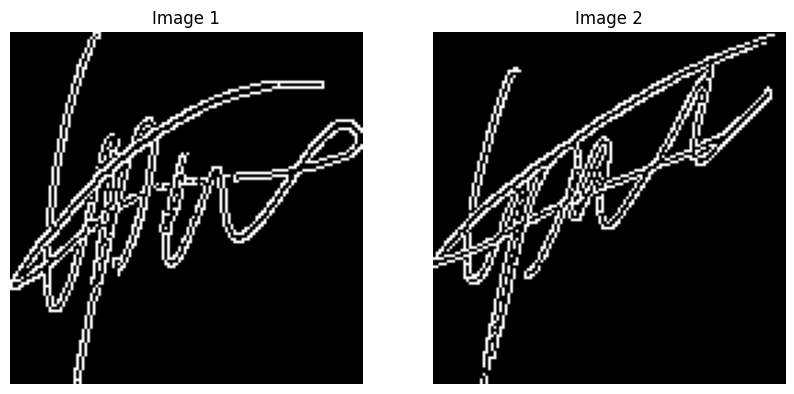

Pair 2:
Label: 0


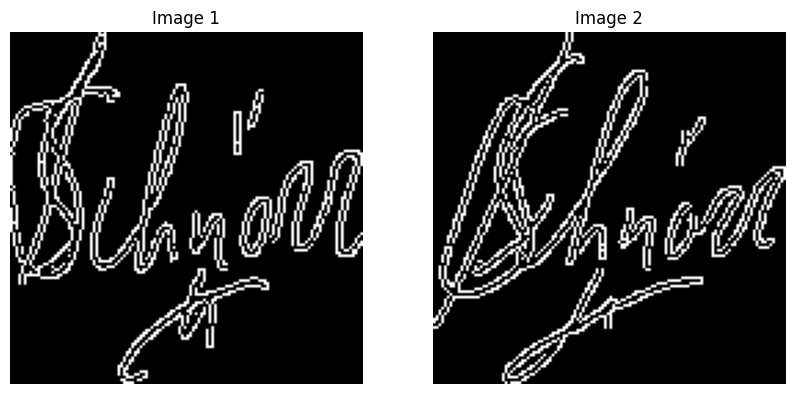

Pair 3:
Label: 0


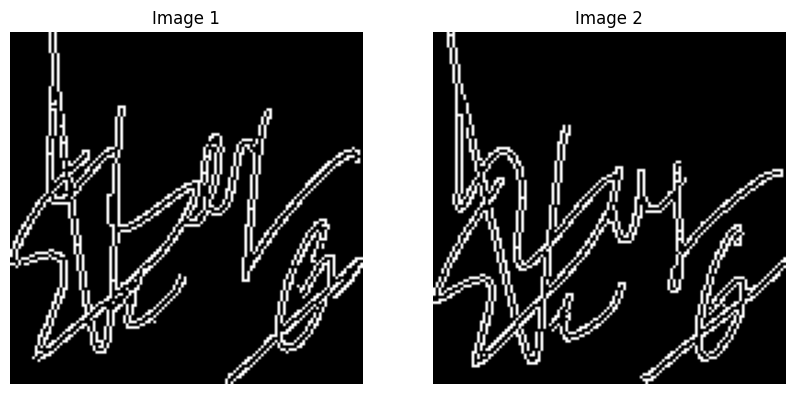

Pair 4:
Label: 1


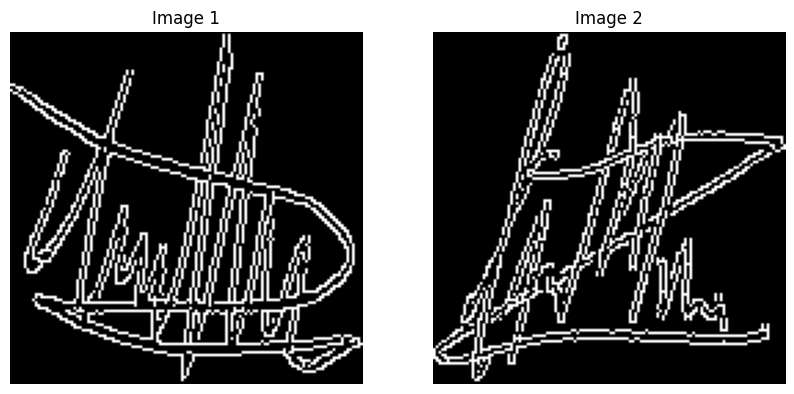

Pair 5:
Label: 0


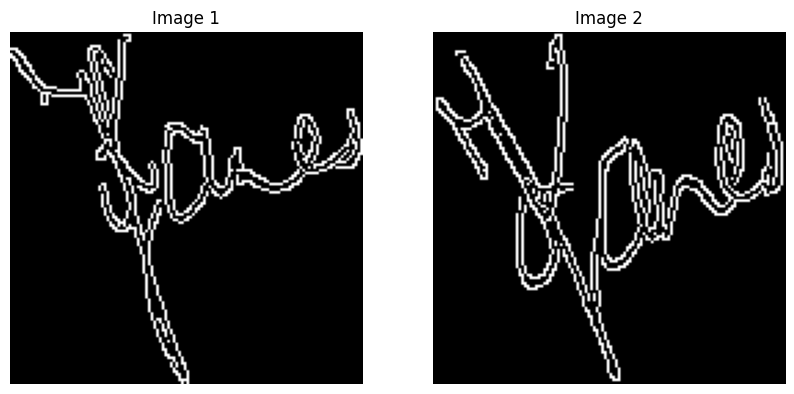

In [6]:
# Create data generator
generator = train_gen.datagen()

# Plot 5 1st images in batch
for i in range(5):
    batch_data, label = next(generator)
    
    pair_data = batch_data["image1"], batch_data["image2"]
    
    print(f"Pair {i+1}:")
    print("Label:", label[0]) 
    
    plt.figure(figsize=(10, 5))
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(pair_data[j][0], cmap='gray')
        plt.title('Image {}'.format(j+1))
        plt.axis('off')
    
    plt.show()

In [7]:
def create_siamese_model(input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    
    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    embedding1 = model(input1)
    embedding2 = model(input2)

    manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    manhattan_distance = manhattan_distance_layer([embedding1, embedding2])


    output = Dense(1, activation='sigmoid')(manhattan_distance)

    return Model(inputs=[input1, input2], outputs=output)

In [8]:
input_shape = (128, 128, 1) 

In [9]:
model = create_siamese_model(input_shape)
model.summary()
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image2 (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │  2,522,624 │ image1[0][0],     │
│ (Sequential)        │                   │            │ image2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,522,753 (9.62 MB)

 Trainable params: 2,522,753 (9.62 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(x=train_gen.datagen(),
                            steps_per_epoch=len(train_set) // 256,
                            epochs=12,
                            validation_data=val_gen.datagen(),
                            validation_steps=len(val_set) // 256)

Epoch 1/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.6109 - loss: 0.6546 - val_accuracy: 0.6287 - val_loss: 0.6201
Epoch 2/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.7259 - loss: 0.5479 - val_accuracy: 0.7982 - val_loss: 0.4600
Epoch 3/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.8177 - loss: 0.4087 - val_accuracy: 0.9064 - val_loss: 0.2688
Epoch 4/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.8972 - loss: 0.2518 - val_accuracy: 0.9621 - val_loss: 0.1399
Epoch 5/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.9476 - loss: 0.1381 - val_accuracy: 0.9769 - val_loss: 0.0764
Epoch 6/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.9641 - loss: 0.0921 - val_accuracy: 0.9834 - val_loss: 0.0514
Epoch 7/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.9767 - loss: 0.0653 - val_accuracy: 0.9901 - val_loss: 0.0314
Epoch 8/12
67/67 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.9831 - loss: 0.0487 - val_accuracy: 0.9955 - v

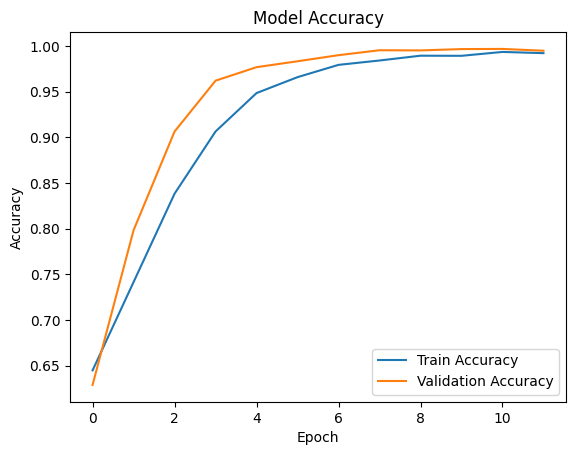

In [11]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [12]:
model.save("../models/SNN.h5")